In [1]:
%matplotlib inline


Finetuning a Torchvision Model to recognize components
===============================================





I have downloaded components for six different classes: 16pin QFN Package, RJ45 CAT5, SFP, SFP+, USB TypeA 4Pos, USB3 TypeC. 24Pos. For training I use between 5 and 28 images in each class and for validation between 1 and 3 images.

I train and validate a model using feature extraction with a pretrained CNN. In feature extraction we start with a pretrained CNN model but only update the final layer weights from which we can make predictions. The only layer that is changed then is the final layer.

The method follows these steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step

In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


Inputs
------

Here are all of the parameters to change for the run. I load images for components
in six different classes: 16pin QFN Package, RJ45 CAT5, SFP, SFP+, USB TypeA 4Pos, USB3 TypeC 24Pos.

It is structured so that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory where the dataset is placed. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:
::

   [resnet, alexnet]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.


In [3]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure

data_dir = "data"
# Models to choose from [resnet, alexnet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions. The helper functions are moved to file computil.py.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [4]:
input_size = 224
model_ft = None

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Initializing Datasets and Dataloaders...


Initialize and Reshape the Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Resnet

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

Alexnet

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier.

In [6]:
import computil as comp

In [7]:
model_ft, input_size = comp.initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [8]:

# Send the model to processor
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.003)

Params to learn:
	 fc.weight
	 fc.bias


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [9]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#inputs = inputs.to(device)
#labels = labels.to(device)

# Train and evaluate
model_name, hist = comp.train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)#, is_inception=(model_name=="resnet")

Epoch 0/14
----------
train Loss: 1.8643 Acc: 0.3235
val Loss: 1.8086 Acc: 0.4444

Epoch 1/14
----------
train Loss: 1.4173 Acc: 0.5147
val Loss: 1.9664 Acc: 0.2222

Epoch 2/14
----------
train Loss: 1.1919 Acc: 0.5441
val Loss: 1.4755 Acc: 0.4444

Epoch 3/14
----------
train Loss: 1.0163 Acc: 0.6176
val Loss: 1.0897 Acc: 0.6667

Epoch 4/14
----------
train Loss: 1.0273 Acc: 0.6618
val Loss: 1.1336 Acc: 0.4444

Epoch 5/14
----------
train Loss: 0.8495 Acc: 0.6618
val Loss: 0.7962 Acc: 0.6667

Epoch 6/14
----------
train Loss: 0.8468 Acc: 0.7353
val Loss: 0.9314 Acc: 0.5556

Epoch 7/14
----------
train Loss: 0.8706 Acc: 0.7059
val Loss: 0.6791 Acc: 0.7778

Epoch 8/14
----------
train Loss: 0.9733 Acc: 0.6765
val Loss: 0.5536 Acc: 0.8889

Epoch 9/14
----------
train Loss: 0.7562 Acc: 0.6912
val Loss: 0.8737 Acc: 0.6667

Epoch 10/14
----------
train Loss: 0.8559 Acc: 0.6765
val Loss: 0.4595 Acc: 0.8889

Epoch 11/14
----------
train Loss: 0.8807 Acc: 0.6618
val Loss: 0.5589 Acc: 0.7778

Ep

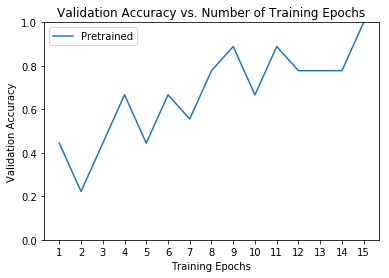

In [10]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method
ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

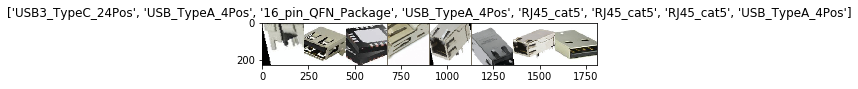

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

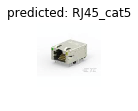

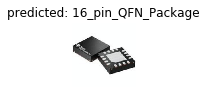

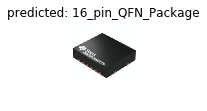

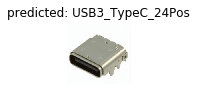

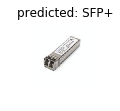

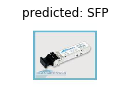

In [13]:
visualize_model(model_ft)